In [1]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:54<00:00, 21.0MB/s]
100% 2.29G/2.29G [01:54<00:00, 21.5MB/s]


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from tqdm.notebook import tqdm as tq
import random
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import shutil

In [3]:
with zipfile.ZipFile("chest-xray-pneumonia.zip","r") as zip_ref:
    zip_ref.extractall()

In [4]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

combined_dir = "chest_xray/dataset"

os.makedirs(combined_dir, exist_ok=True)

In [5]:
for category in os.listdir(train_dir):
  category_dir = os.path.join(train_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
  category_dir = os.path.join(test_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

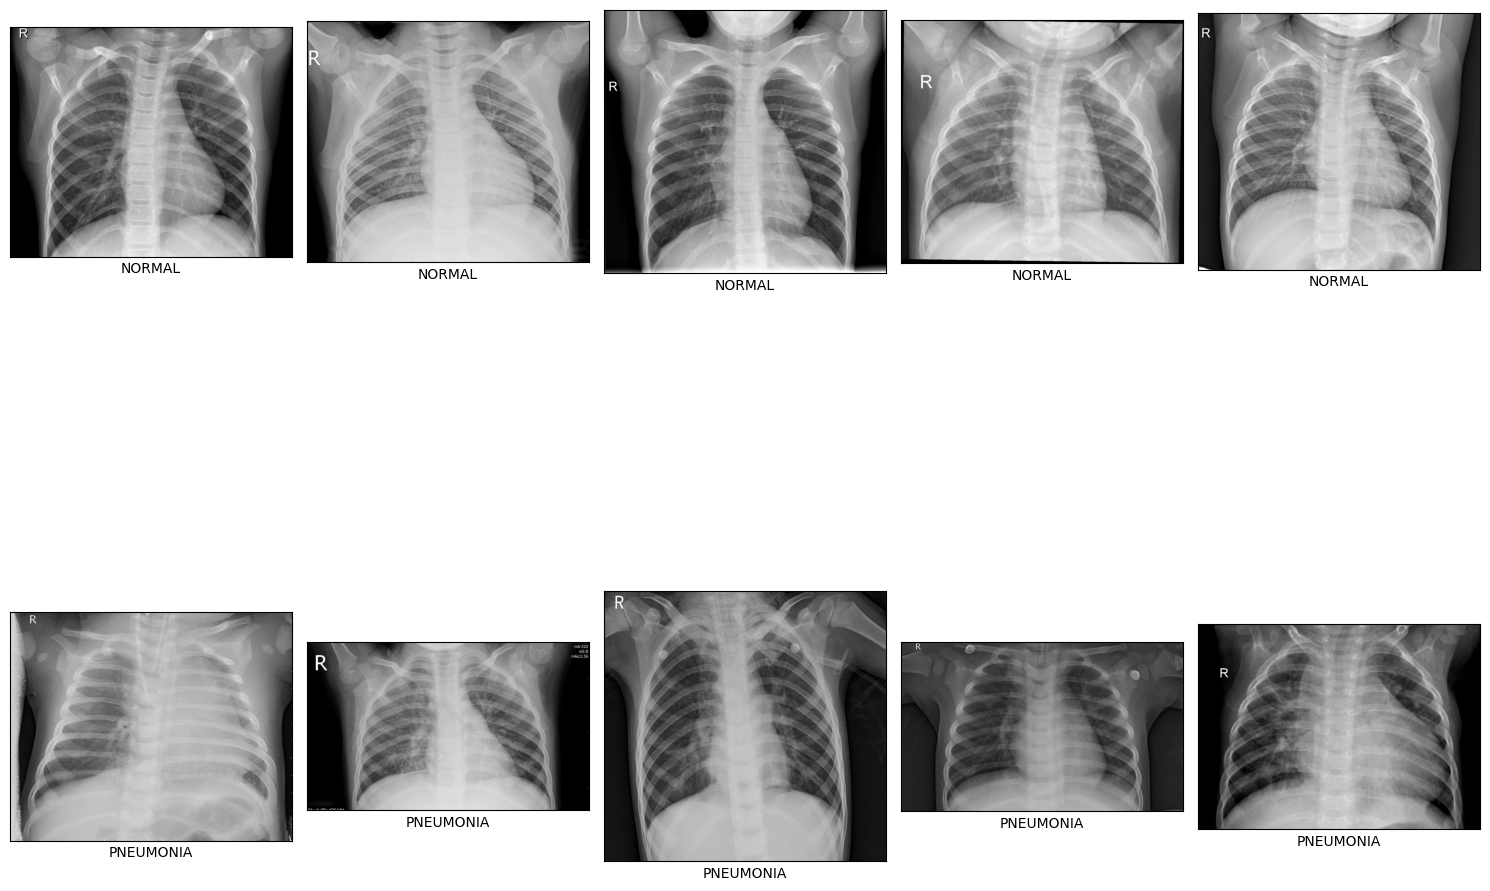

In [6]:
lung_image = {}

path = "chest_xray/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
  lung_image[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "chest_xray/dataset/"

fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
  images = np.random.choice(lung_image[class_name], 5, replace=False)

  for j, image_name in enumerate(images):
    img_path = os.path.join(path_sub, class_name, image_name)
    img = Image.open(img_path).convert("L")
    axs[i, j].imshow(img, cmap="gray")
    axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

<Axes: xlabel='count', ylabel='labels'>

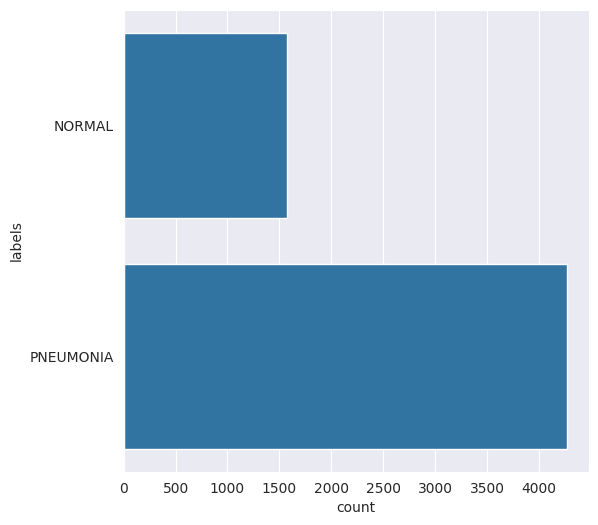

In [7]:
def distribution_plot(data_path):
  lung_path = data_path

  file_name = []
  labels = []
  full_path = []

  for path, subdirs, files in os.walk(lung_path):
    for name in files:
      full_path.append(os.path.join(path, name))
      labels.append(path.split("/")[-1])
      file_name.append(name)

  distribution_train = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

  Label = distribution_train["labels"]
  plt.figure(figsize=(6, 6))
  sns.set_style("darkgrid")
  plot_data = sns.countplot(Label)

  return plot_data

distribution_plot("chest_xray/dataset")

In [8]:
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    angle = random.randint(0,180)
    return rotate(img, angle)

def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    angle = random.randint(0,180)
    return rotate(img, -angle)

def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [9]:
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path="chest_xray/dataset/NORMAL"
augmented_path="chest_xray/dataset/NORMAL"
images = []

for im in os.listdir(images_path):
  images.append(os.path.join(images_path, im))

images_to_generate = 2000
i = 1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0
        transformation_count = random.randint(1, len(transformations))

        while n <= transformation_count:
            key = random.choice(list(transformations))
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)
        cv2.imwrite(new_image_path, transformed_image)
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

<Axes: xlabel='count', ylabel='labels'>

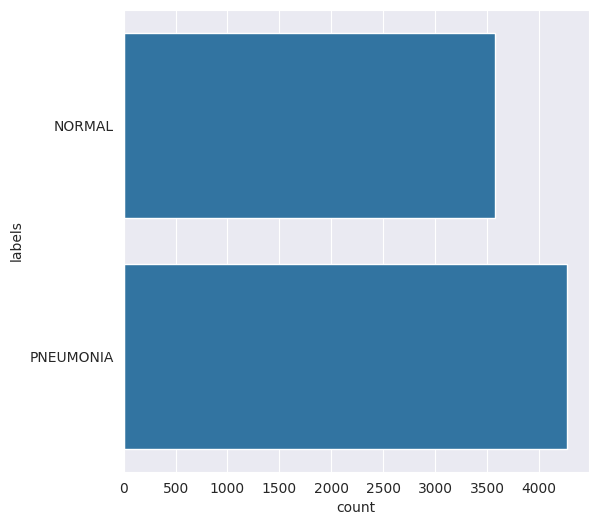

In [10]:
distribution_plot("chest_xray/dataset")

In [11]:
mypath= 'chest_xray/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
NORMAL,3575
PNEUMONIA,4265


In [12]:
X = df['path']
y = df["labels"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300
)

In [13]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [14]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

print(df_all.sample(5))

datasource_path = "chest_xray/dataset/"
dataset_path = "Dataset-Final/"


set    labels   
test   NORMAL        699
       PNEUMONIA     869
train  NORMAL       2876
       PNEUMONIA    3396
dtype: int64 


                                                   path     labels    set
6330  chest_xray/dataset/PNEUMONIA/person1502_virus_...  PNEUMONIA   test
655   chest_xray/dataset/NORMAL/augmented_image_1969...     NORMAL  train
1259  chest_xray/dataset/NORMAL/NORMAL2-IM-0594-0001...     NORMAL  train
1270  chest_xray/dataset/PNEUMONIA/person332_virus_6...  PNEUMONIA  train
3147  chest_xray/dataset/NORMAL/augmented_image_712.jpg     NORMAL  train


In [15]:
for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [16]:
TRAIN_DIR = "Dataset-Final/train"
TEST_DIR = "Dataset-Final/test"

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(150,150),
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False
)

Found 5018 images belonging to 2 classes.
Found 1254 images belonging to 2 classes.
Found 1568 images belonging to 2 classes.


In [17]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95 and logs.get("val_accuracy") > 0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [18]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,367,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,450,433 (9.35 MB)

 Trainable params: 2,450,433 (9.35 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=32,
                    validation_data=val_generator,
                    callbacks=[callbacks])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 230ms/step - accuracy: 0.7185 - loss: 0.5020 - val_accuracy: 0.9123 - val_loss: 0.2474
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - accuracy: 0.9450 - loss: 0.1601 - val_accuracy: 0.9298 - val_loss: 0.2054
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - accuracy: 0.9553 - loss: 0.1267 - val_accuracy: 0.9322 - val_loss: 0.1940
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - accuracy: 0.9573 - loss: 0.1136 - val_accuracy: 0.9418 - val_loss: 0.1620
Epoch 5/30
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9696 - loss: 0.0744
Reached 95% accuracy so cancelling training!
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 189ms/step - accuracy: 0.9696 - loss: 0.0744 - val_accuracy: 0.9506 - val_loss: 0.1443


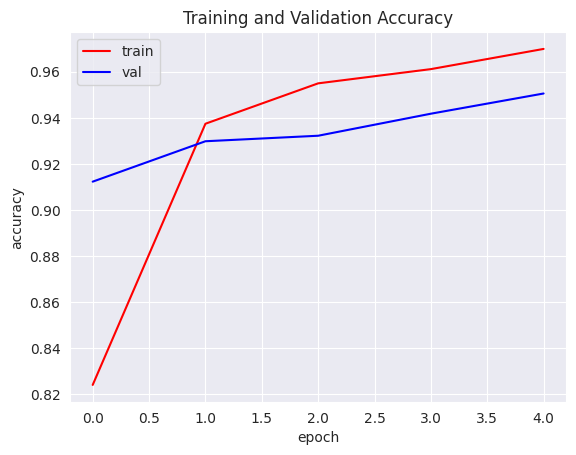

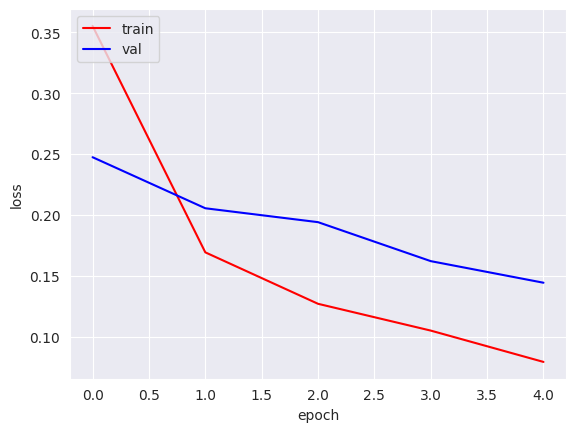

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()




              precision    recall  f1-score   support

      Normal     0.9544    0.9571    0.9557       699
   Pneumonia     0.9654    0.9632    0.9643       869

    accuracy                         0.9605      1568
   macro avg     0.9599    0.9601    0.9600      1568
weighted avg     0.9605    0.9605    0.9605      1568



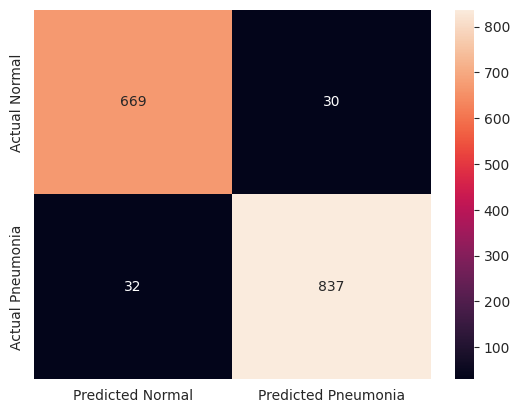

In [22]:
test_generator.reset()

preds = model.predict(test_generator,verbose=0)
preds = preds.copy()
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1

cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds,target_names =['Normal','Pneumonia'], digits=4))

In [24]:
tf.saved_model.save(model, "./pneumonia_model")

In [26]:
!zip -r pneumonia_model.zip ./pneumonia_model

  adding: pneumonia_model/ (stored 0%)
  adding: pneumonia_model/fingerprint.pb (stored 0%)
  adding: pneumonia_model/variables/ (stored 0%)
  adding: pneumonia_model/variables/variables.data-00000-of-00001 (deflated 17%)
  adding: pneumonia_model/variables/variables.index (deflated 65%)
  adding: pneumonia_model/assets/ (stored 0%)
  adding: pneumonia_model/saved_model.pb (deflated 87%)
